# Saliency maps for understanding the aesthetics features that the network is looking for in the pictures
A significant portion of the code below was adapted from this repository: https://github.com/sar-gupta/convisualize_nb/blob/master/cnn-visualize.ipynb

It is assumed that the aesthetics network has a 1-dimensional output. 

## Imports and general code preparation

In [531]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import PIL
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")
from PIL import Image
plt.ion()   # interactive mode
from random import randint
from sklearn.model_selection import train_test_split


In [532]:
root_dir = os.path.abspath('')
data_dir = os.path.join(root_dir, 'Images')
# check for existence
os.path.exists(root_dir)
os.path.exists(data_dir)
workers_test = pd.read_csv(os.path.join(data_dir,  'test_workers_dataset_normalized.csv'), sep=' ')

In [533]:
from PIL import Image
class ImageRatingsDataset(Dataset):
    """Images dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.images_frame = pd.read_csv(csv_file, sep=' ')
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.images_frame)

    def __getitem__(self, idx):
        try:
            img_name = str(os.path.join(self.root_dir,str(self.images_frame.iloc[idx, 0])))
            im = Image.open(img_name).convert('RGB')
            if im.mode == 'P':
                im = im.convert('RGB')
            image = np.asarray(im)
            #image = io.imread(img_name+'.jpg', mode='RGB').convert('RGB')
            rating = self.images_frame.iloc[idx, 1]
            sample = {'image': image, 'rating': rating}

            if self.transform:
                sample = self.transform(sample)
            return sample            
        except Exception as e:
            pass
        

            
        

In [534]:
import random
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, rating = sample['image'], sample['rating']
        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        image = transform.resize(image, (new_h, new_w))

        return {'image': image, 'rating': rating}

        
    

class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, rating = sample['image'], sample['rating']
        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]


        return {'image': image, 'rating': rating}

class RandomHorizontalFlip(object):
    def __init__(self, p):
        self.p = p
    
    def __call__(self, sample):
        
        image, rating = sample['image'], sample['rating']
        if random.random() < self.p:
            image = np.flip(image, 1)
            #image = io.imread(img_name+'.jpg', mode='RGB').convert('RGB')
        return {'image': image, 'rating': rating}

class Normalize(object):
    def __init__(self ):
        self.means=np.array([0.485, 0.456, 0.406]) 
        self.stds=np.array([0.229, 0.224, 0.225])
        
    def __call__(self, sample):
        image, rating = sample['image'], sample['rating']
        im=image/255
        im[:,:,0]=(image[:,:,0] - 0.485)/ 0.229 
        im[:,:,1]=(image[:,:,1]  - self.means[1])/ self.stds[1]
        im[:,:,2]=(image[:,:,2]  - self.means[2])/ self.stds[2]
        image=im
        return {'image': image, 'rating': rating}

    
    
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, rating = sample['image'], sample['rating']
        
        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
            
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image).double(),
                'rating': torch.from_numpy(np.float64([rating])).double()}

In [535]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import copy
from torch import nn
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode
from random import randint

## Preparing and loading the network 
### Note that this step is important, as we want to be able to reference each layer with its proper name, not just compute its output/input

In [536]:
from torchvision import models
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Sequential(nn.Dropout(0.5),nn.Linear(num_ftrs,1))

In [537]:
class BaselineModel(nn.Module):
    def __init__(self, num_classes, keep_probability, inputsize):
    
        super(BaselineModel, self).__init__()
        self.fc1 = nn.Linear(inputsize, 256)
        self.drop_prob = (1 - keep_probability)
        self.relu1= nn.PReLU()
        self.drop1 = nn.Dropout(self.drop_prob)
        self.bn1=nn.BatchNorm1d(256)
        self.fc2=nn.Linear(256,256)
        self.relu2=nn.PReLU()
        self.drop2 = nn.Dropout(p=self.drop_prob)
        self.bn2=nn.BatchNorm1d(256)
        self.fc3 = nn.Linear(256, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                # Weight initialization reference: https://arxiv.org/abs/1502.01852
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def forward(self, x):
        """
        Feed-forward pass.
        :param x: Input tensor
        : return: Output tensor
        """
        out=self.fc1(x)
        out =self.relu1(out)
        out=self.drop1(out)
        out=self.bn1(out)
        out=self.fc2(out)
        out=self.relu2(out)
        out=self.drop2(out)
        out=self.bn2(out)
        out=self.fc3(out)
        return out

In [538]:
class convNet(nn.Module):
    #constructor
    def __init__(self,resnet,mynet):
        super(convNet, self).__init__()
        #defining layers in convnet
        self.resnet=resnet
        self.myNet=mynet
    def forward(self, x):
        x=self.resnet(x)
        x=self.myNet(x)
        return x

In [539]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.out_features
net1 = BaselineModel(1, 0.5,num_ftrs)
net2=convNet(resnet=model_ft, mynet=net1)

In [540]:
#Manually add the adapters into the pretrain network
class rsn18 (nn.Module):
    def __init__(self):
        super(rsn18, self).__init__()
        self.conv1 = models.resnet18().conv1
        self.bn1=models.resnet18().bn1
        self.relu=models.resnet18().relu
        self.maxpool=models.resnet18().maxpool
        self.adapter1=nn.Conv2d(64,64, kernel_size=1, padding=0)

        self.layer1=models.resnet18().layer1
        self.adapter2=nn.Conv2d(64,128, kernel_size=1, padding=0, stride=2)
        self.layer2=models.resnet18().layer2
        self.adapter3=nn.Conv2d(128,256, kernel_size=1, padding=0, stride=2)
        self.layer3=models.resnet18().layer3
        self.adapter4=nn.Conv2d(256,512, kernel_size=1, padding=0, stride=2)
        self.layer4=models.resnet18().layer4
        self.avgpool=models.resnet18().avgpool
        nn.init.xavier_uniform_(self.adapter1.weight, gain=0.01)
        nn.init.xavier_uniform_(self.adapter2.weight, gain=0.01)
        nn.init.xavier_uniform_(self.adapter3.weight, gain=0.01)
        nn.init.xavier_uniform_(self.adapter4.weight, gain=0.01)

        self.fc=models.resnet18().fc
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x) + self.adapter1(x)
        x = self.layer2(x) + self.adapter2(x)
        x = self.layer3(x)+ self.adapter3(x)
        x = self.layer4(x)+ self.adapter4(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [541]:
rs=rsn18()

In [542]:
class convNet2(nn.Module):
    #constructor
    def __init__(self,resnet,mynet):
        super(convNet2, self).__init__()
        #defining layers in convnet
        self.rsn=resnet
        self.myNet=mynet
    def forward(self, x):
        x=self.rsn(x)
        x=self.myNet(x)
        return x

In [543]:
cnvnet2=convNet2(resnet=rs, mynet=net1)

In [544]:
net_2=torch.load('A192LAQKHD9LWnetwork_0 K100 adapters it0.pt')

In [545]:
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
use_gpu = True
if use_gpu:
    cuda = torch.device('cuda:0')     # Default CUDA device
count=0
torch.cuda.set_device(cuda.index)

In [546]:
from torch.autograd import Variable
from torchvision import models
from torchvision import transforms, utils

In [547]:
import scipy.misc
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
import json

## Preprocessing and other methods to be used to compute the saliency maps
### As in the other scripts, the normalization was made using the ImageNet normalization constants

In [548]:
def to_grayscale(image):
    """
    input is (d,w,h)
    converts 3D image tensor to grayscale images corresponding to each channel
    """
    image = torch.sum(image, dim=0)
    image = torch.div(image, image.shape[0])
    return image

In [549]:
def normalize(image):
    normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
    )
    preprocess = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    normalize
    ])
    image = Variable(preprocess(image).unsqueeze(0))
    return image

def deprocess(image):
    return image * torch.Tensor([0.229, 0.224, 0.225]).cuda()  + torch.Tensor([0.485, 0.456, 0.406]).cuda()

def load_image(path):
    image = Image.open(path)
    plt.imshow(image)
    plt.title("Image loaded successfully")
    return image

### Load the image. We loaded an example image from the FLICKR-AES repository, but it works with any picture

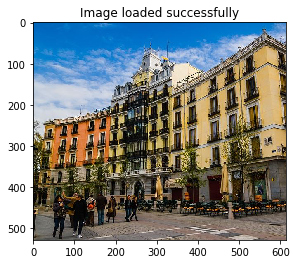

In [550]:
image = load_image("./Images/madrid.jpg" )

In [551]:
#Obtain the names of the layers in the network, normalize the images
modulelist = list(net_2.modules())

In [552]:
image_2 = normalize(image)

In [553]:
normalise = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
    )
preprocess = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    normalise
    ])

In [554]:
def make_saliency_map(input, label):
    input = Variable(preprocess(input).unsqueeze(0).cuda(), requires_grad=True)
    output = net_2.forward(input)
    output[0].backward()
    grads = input.grad.data.clamp(min=0)
    grads.squeeze_()
    grads.transpose_(0,1)
    grads.transpose_(1,2)
    grads = np.amax(grads.cpu().numpy(), axis=2)
    
    true_image = input.data
    true_image = true_image.squeeze()
    true_image = true_image.transpose(0,1)
    true_image = true_image.transpose(1,2)
    true_image = deprocess(true_image)

    fig = plt.figure()
    plt.rcParams["figure.figsize"] = (20, 20)


    a = fig.add_subplot(1,2,1)
    imgplot = plt.imshow(true_image)
    plt.title('Original Image')
    plt.axis('off') 

    a = fig.add_subplot(1,2,2)
    imgplot = plt.imshow(grads)
    plt.axis('off') 
    plt.title('Saliency Map')
    
    return grads

# Picture enhancement using gradient ascent. 
## Note that we are using the same image as before, if we want to change it, we can simply load another image
First we compute the output the network given the image, backpropagate the loss (MSE loss compared to an image rating of 2, which would be 2 standards deviation above the mean of 0, thus being a 95% percentile image. This is done so that gradient ascent algorithm makes the pixels change in the direction that would improve their aesthetic rating ). If the image is above the 95 percentile (eg it has a rating of more than 2), this value has to be changed to, for example, 3.

Second, we compute the gradient of the loss function with respect to the input image.

Finally, we change the input image to Image_new = Image + Eps * Gradient (Eps controls the intensity of the change, values of around 0.5 work best, as smaller values create non-noticeable changes and greater values perturb the images too much)

We save the three images (Image, Eps*Gradient, Image_new)

In [568]:
#import required libs
import torch
import torch.nn
from torch.autograd.gradcheck import zero_gradients
import torch.nn.functional as F
import torchvision.models as models
from PIL import Image
from torchvision import transforms
import numpy as np
import requests, io
import matplotlib.pyplot as plt
from torch.autograd import Variable
%matplotlib inline

In [569]:
img_variable = Variable(image_2.cuda(), requires_grad=True) #convert tensor into a variable

In [570]:
output = net_2.forward(img_variable)[0]

In [571]:
output =Variable(output, requires_grad=True)

In [572]:
target = Variable(torch.FloatTensor([2]).cuda(), requires_grad=False)
loss = torch.nn.MSELoss()
loss_cal = loss(output, target)
loss_cal.backward(retain_graph=True)

In [573]:
eps = .6
x_grad = img_variable                #calculate the sign of gradient of the loss func (with respect to input X) (adv)
x_adversarial = img_variable.data + eps * x_grad          #find adv example using formula shown above
output_adv = net_2.forward(Variable(x_adversarial))   #perform a forward pass on adv example


### Output_adv is the expected rating of the enhanced image, output is the predicted rating of the original picture

In [574]:
output_adv

tensor([[-0.5623]], device='cuda:0')

In [575]:
output

tensor([-0.6089], device='cuda:0')

In [576]:
mean=np.asarray([0.485, 0.456, 0.406])
std=np.asarray([0.229, 0.224, 0.225])

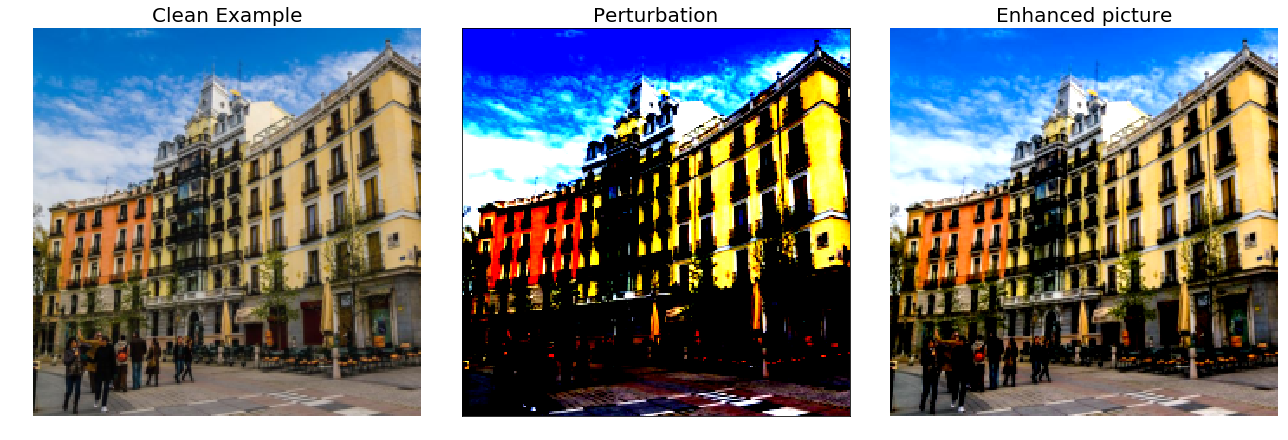

In [577]:
x=img_variable.cpu().detach().numpy()
x_adv=x_adversarial
x_adv = x_adv.squeeze(0)
x_adv = x_adv.mul(torch.FloatTensor(std).cuda().view(3,1,1)).add(torch.FloatTensor(mean).cuda().view(3,1,1)).cpu().detach().numpy()#reverse of normalization op
x_adv = np.transpose( x_adv , (1,2,0))   # C X H X W  ==>   H X W X C
x_adv = np.clip(x_adv, 0, 1)

x_grad = np.transpose(x_grad[0].cpu().detach().numpy(), (1,2,0))
x_grad = np.clip(x_grad, 0, 1)

figure, ax = plt.subplots(1,3, figsize=(18,8))

true_image = normalize(image)
true_image = true_image.squeeze()
true_image = true_image.transpose(0,1)
true_image = true_image.transpose(1,2)
true_image = deprocess(true_image.data.cuda())
ax[0].imshow(true_image)
ax[0].set_title('Clean Example', fontsize=20)


ax[1].imshow(x_grad)
ax[1].set_title('Perturbation', fontsize=20)
ax[1].set_yticklabels([])
ax[1].set_xticklabels([])
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[2].imshow(x_adv)
ax[2].set_title('Enhanced picture', fontsize=20)

ax[0].axis('off')
ax[2].axis('off')
plt.tight_layout()
figure.savefig('adversarial_madrid.png')